In [1]:
import numpy as np
import scipy.io.wavfile
import os
import librosa as lb
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Activation , Flatten , Conv2D , MaxPooling2D , ZeroPadding2D , Conv1D , MaxPool1D,MaxPooling1D
from matplotlib import pyplot as plt
from IPython.display import Audio
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
# from google.colab import drive 
#drive.mount('/content/drive')
#!unrar  x '/content/drive/MyDrive/crema/Crema.rar' -d '/content/'



In [3]:
MAX_FILES = 7442
FILE_LIMIT = 7442

# The folder containing the Crema dataset
dataFolder = '/data/Crema'

# The names of all files in the Crema dataset
soundFiles = os.listdir(path=dataFolder)
soundFiles.sort()
soundFiles[0]
# Sanity check: checking if all sound files are downloaded correctly
# Spoiler: They were.
len(soundFiles)

7442

In [36]:
#bisho: we will read every sample into fs(sampling freq) and data.
#and create labels array by checking every name for words SAD,ANG,DIS,FEA,HAP,and NEU and save them as corresponding labels 0,1,2,3,4,and 5 respectivly
# 6 is an error/unknown emotion
labels=np.zeros(FILE_LIMIT)

classes={0:"SAD" , 1:"ANGRY" , 2:"DISGUST" , 3:"FEAR" , 4:"HAPPY" , 5:"NEUTRAL"}
fs={}
data=[]
i=0
for sample in soundFiles:
    
    # fs[i], data[i] = scipy.io.wavfile.read(dataFolder+"/"+sample)
    samp, sr = lb.load(dataFolder+"/"+sample, offset=0.6, duration=3 , sr=None)
    data.append(samp)
    # print(sample)
    token = sample.partition(".wav")[0].split("_")
    if token[2] == 'SAD':
        labels[i]=0;
    elif token[2] == 'ANG':
        labels[i]=1;
    elif token[2] == 'DIS':
        labels[i]=2;
    elif token[2] == 'FEA':
        labels[i]=3;
    elif token[2] == 'HAP':
        labels[i]=4;
    elif token[2] == 'NEU':
        labels[i]=5;
    else:
        labels[i]=6;

    i=i+1

    # To reduce loading time while developing
    if i >= FILE_LIMIT:
        break;
    # print(i, ' ', end='')



mx=80080
mn=20287
#padding
k=int(data[0].shape[0])
for i in range(FILE_LIMIT):
    data[i]=np.pad(data[i], pad_width=(0,48000-data[i].shape[0]))
    k=int(data[i].shape[0])
    #print(k)
#length limit
for i in range(FILE_LIMIT):
    #data[i]=data[i][0:(mn)] #reducing sample sizes to be equal
    k=data[i].shape[0]
    #data[i]=librosa.effects.time_stretch(data[i], ( k/ (2.5*sr))  )
    #print(data[i].shape)

#bisho: later we might want to use noise , stretching , pitching , shifting variations to improve accuracy






ANGRY


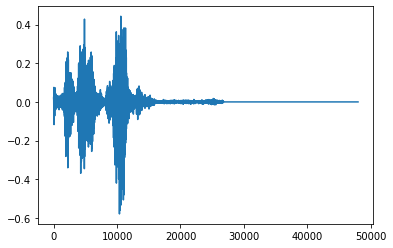

DISGUST


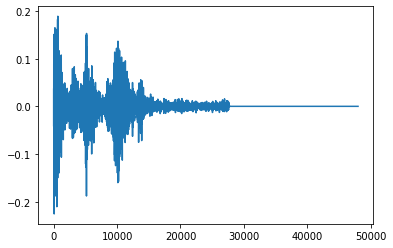

FEAR


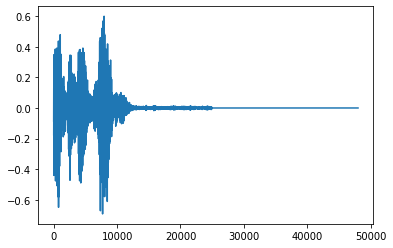

HAPPY


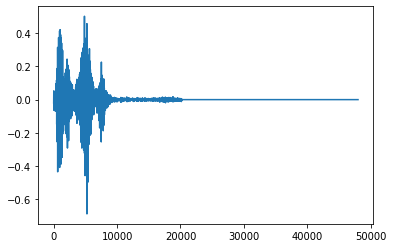

NEUTRAL


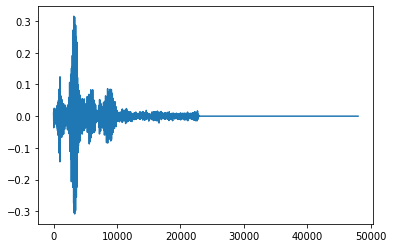

SAD


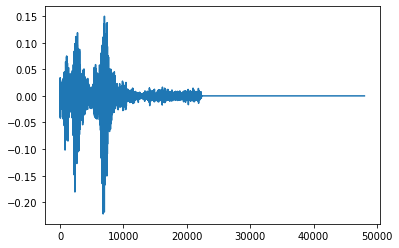

In [40]:
cls_samples=[]
cls_samples.append(0)
clses=[0,1,2,3,4,5]
clses.remove( labels[0] )
for i in range(5209-1):
    if(labels[i+1]!=labels[i] and (labels[i+1] in clses)):
        cls_samples.append(i+1)
        clses.remove(labels[i+1])
        #print(labels[i+1])
        if(len(cls_samples)==6):
            break;


#bisho : ploting melspectogram and time domain for the first audio in each class (emotion)
for i in cls_samples:

  print(classes[labels[i]])
  plt.plot(data[i])
  plt.show()
  Audio(np.array(data[i]) , rate= 16000 )

In [41]:
import math
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [42]:

from sklearn.model_selection import train_test_split
#spliting dataset

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3 ,shuffle = False, stratify = None)
print(x_train[0].shape)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
sh=x_train.shape[1]
print(x_train[0].shape)
print(sh)
#augmenting training dataset
moded_xtrain = []
moded_ytrain=[]
for i in range(x_train.shape[0]):

  withnoise = get_white_noise(x_train[i] ,7)
  withpitch=librosa.effects.pitch_shift(x_train[i], sr , 0.7)
  #stretched =  librosa.effects.time_stretch(x_train[i], 0.8)
  moded_xtrain.append(x_train[i])
  moded_xtrain.append(withnoise)
  moded_xtrain.append(withpitch)
  
  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])

(48000,)
(48000,)
48000


In [ ]:
port= len(moded_xtrain)/10; # take 5 percent wiTH zero frequency and distrbute labels equally on them 
port= port-port%6;
port=int(port)
for i in range(port) :
  moded_xtrain.append(np.zeros(40000))
  moded_ytrain.append(i%6)


In [43]:
def zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512)
    return np.squeeze(zcr)
def mfcc(data, sr=16000, flatten: bool = True): #get Mel-frequency cepstrum coefficients 
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)
def rmse(data): #energy for each frame
    rmse = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    return np.squeeze(rmse)
def energy(data):
    ene = np.array([np.sum(np.power(np.abs(data[hop:hop+2048]), 2)) for hop in range(0, data.shape[0], 512)])
    return ene / 2048
  

In [44]:

idx = 0
x=[]
for i in moded_xtrain :
  sample = np.array([])
  sample = np.hstack( (sample ,zcr(i),rmse(i),mfcc(i),energy(i)))
  print(sample.shape)
  idx =idx+1
  x.append(sample)

Streaming output truncated to the last 5000 lines.
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162

In [46]:

#print(X_test.shape)
idx = 0
x_t=[]
for i in x_test :
  sample = np.array([])
  sample = np.hstack(  (sample ,zcr(i),rmse(i),mfcc(i),energy(i)))
  print(sample.shape)
  idx =idx+1
  x_t.append(sample)

(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)
(2162,)


In [47]:
  moded_xtrain= np.array(x)
  moded_xtest=np.array(x_t)

In [48]:

print(moded_xtest.shape)
moded_xtest = np.expand_dims(moded_xtest, axis=2)
print(moded_xtest.shape)
moded_xtrain = np.expand_dims(moded_xtrain, axis=2)

(2233, 2162)
(2233, 2162, 1)


In [49]:
print(moded_xtrain.shape[1])
#moded_ytrain=np.array(moded_ytrain)

2162


In [50]:
from keras import models
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(moded_xtrain.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2162, 512)         3072      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2162, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1081, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1081, 512)         1311232   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1081, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 541, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 541, 256)          6

In [51]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [52]:
from tensorflow.keras.utils import to_categorical
ytrain=to_categorical(moded_ytrain)
ytest=to_categorical(y_test)
print(moded_xtrain.shape)
print(moded_xtest.shape)

record=model.fit(moded_xtrain , ytrain , epochs=30, validation_data=(moded_xtest, ytest), callbacks=[reduction])

(15627, 2162, 1)
(2233, 2162, 1)
Epoch 1/30
489/489 [==============================] - 85s 154ms/step - loss: 1.6454 - accuracy: 0.3592 - val_loss: 4.1234 - val_accuracy: 0.3189
Epoch 2/30
489/489 [==============================] - 80s 164ms/step - loss: 1.4470 - accuracy: 0.4127 - val_loss: 1.8234 - val_accuracy: 0.3793
Epoch 3/30
489/489 [==============================] - 80s 164ms/step - loss: 1.3799 - accuracy: 0.4478 - val_loss: 1.8939 - val_accuracy: 0.3883
Epoch 4/30
489/489 [==============================] - 80s 164ms/step - loss: 1.3384 - accuracy: 0.4653 - val_loss: 1.5701 - val_accuracy: 0.3972
Epoch 5/30
489/489 [==============================] - 80s 164ms/step - loss: 1.2980 - accuracy: 0.4777 - val_loss: 1.9052 - val_accuracy: 0.4169
Epoch 6/30
489/489 [==============================] - 80s 164ms/step - loss: 1.2580 - accuracy: 0.4916 - val_loss: 1.5721 - val_accuracy: 0.4178
Epoch 7/30
489/489 [==============================] - 80s 164ms/step - loss: 1.2155 - accuracy: 0

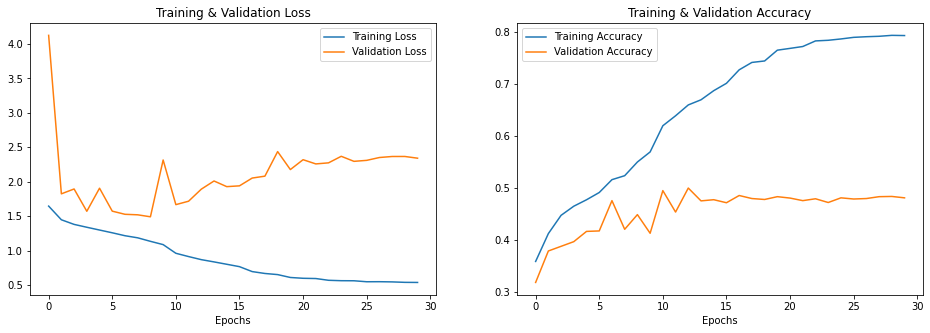

              precision    recall  f1-score   support

         0.0       0.47      0.40      0.43       382
         1.0       0.61      0.69      0.65       381
         2.0       0.44      0.44      0.44       381
         3.0       0.40      0.39      0.40       381
         4.0       0.47      0.46      0.47       381
         5.0       0.47      0.52      0.49       327

    accuracy                           0.48      2233
   macro avg       0.48      0.48      0.48      2233
weighted avg       0.48      0.48      0.48      2233



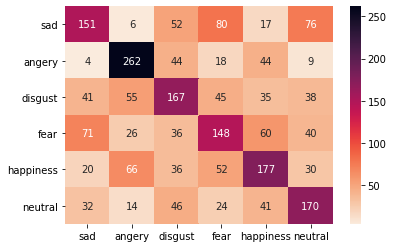

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
#graphs , confusion matrix ,and f meausre
train_ac = record.history['accuracy']
train_loss = record.history['loss']
test_ac = record.history['val_accuracy']
test_loss = record.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_ac, label = 'Training Accuracy')
ax[1].plot(test_ac , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


#SAD,ANG,DIS,FEA,HAP,and NEU and save them as corresponding labels 0,1,2,3,4,5,and 6 respectivly
y_pred = model.predict(moded_xtest)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))


matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'], yticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'])


In [ ]:
1